In [2]:
!cd .. && git submodule init
!cd .. && git submodule update
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake\
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: no se puede crear el directorio «build»: El archivo ya existe
-- The C compiler identification is GNU 4.8.5
-- The CXX compiler identification is GNU 4.8.5
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
Release mode
-- Found PythonInterp: /home/alicia/.pyenv/versions/3.6.5/bin/python (found version "3.6.5") 
-- Found PythonLibs: /home/alicia/.pyenv/versions/3.6.5/lib/libpython3.6m.a
-- pybind11 v2.3.dev0
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/alicia/Documentos/Metodos Numericos/TP3/metodos-tp3
-- Configuring done
-- Generating done
-- Build files have been written to: /home/alicia/Documentos/Metodos Numericos/

In [5]:
!pwd
!python --version


/home/alicia/Documentos/Metodos Numericos/TP3/metodos-tp3/notebooks
Python 3.6.5


In [6]:
import linearregression
import pandas as pd
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import time
import math
import calendar
import datetime
import matplotlib.dates as mdates
import sys
import pickle

In [7]:
def outliers_cuartil(df):
    q1 = df["Delay"].quantile(0.25)
    q3 = df["Delay"].quantile(0.75)
    d = q3-q1
    df = df[df.Delay > q1- d*1.5]
    df = df[df.Delay < q3 +d*1.5]
    return df

In [8]:
def cross_validation(df,label_x,label_y,particiones,funcion,grado):
    particion_anterior = 0
    diferencias = []
    tam_particion = int(df[label_x].count()/particiones)
    for i in range(particiones):
        if i != particiones-1:
            particion = int(df[label_x].count()/particiones)*(i+1)
            #data_train  = df[label_x][:particion]
            data_train = df.index[:particion]
            #data_test   = df[label_x][particion:particion+tam_particion]
            data_test   = df.index[particion:particion+tam_particion]
            label_train = df[label_y][:particion]
            label_test  = df[label_y][particion:particion+tam_particion]
            particion_anterior = particion
            tp3 = linearregression.CuadradosMinimos(funcion)
            tp3.fit(grado, data_train, label_train)
            ys = tp3.predict(data_test)            
            diferencias.append(sum((ys-label_test)**2))
        #el ultimo se tiene que descartar porque por como agarro las particiones la ultima se compararia a si
        #misma ABS
    RMSE = (sum(diferencias)/(particiones-1))**(1./2)
    return RMSE

In [9]:
def cross_validation_fusion(df,label_x,label_y,particiones,funcion,grado,pi):
    particion_anterior = 0
    diferencias = []
    tam_particion = int(df[label_x].count()/particiones)
    for i in range(particiones):
        if i != particiones-1:
            particion = int(df[label_x].count()/particiones)*(i+1)
            #data_train  = df[label_x][:particion]
            data_train = df.index[:particion]
            #data_test   = df[label_x][particion:particion+tam_particion]
            data_test   = df.index[particion:particion+tam_particion]
            label_train = df[label_y][:particion]
            label_test  = df[label_y][particion:particion+tam_particion]
            particion_anterior = particion
            tp3 = linearregression.CuadradosMinimos(funcion)
            tp3.fit_fusion(grado,pi, data_train, label_train)
            ys = tp3.predict(data_test)            
            diferencias.append(sum((ys-label_test)**2))
        #el ultimo se tiene que descartar porque por como agarro las particiones la ultima se compararia a si
        #misma ABS
    RMSE = (sum(diferencias)/(particiones-1))**(1./2)
    return RMSE

In [14]:
# Graficos los datos reales para tenerlos como referencia

def entrenar_y_predecir_en_rangos(df,rango_entrenamiento, rango_prediccion,familia):
    #yolo
    particiones = 3
    if familia != 'fusion':
        regr = linearregression.CuadradosMinimos(familia)
        df_entrenamiento = df[df.index.isin(rango_entrenamiento)]    
        xi =df_entrenamiento.index.values.astype(float)
        # 'Fiteo' los datos de entrenamiento
        grado = 0
        min_rmse = cross_validation(df,'Date','Delay',particiones,familia,grado)
        mejor_grado = 0
        if familia == 'pol':
            while grado <= 20:
                rmse = cross_validation(df,'Date','Delay',particiones,familia,grado)
                grado += 1
                if min_rmse > rmse:
                    min_rmse = rmse
                    mejor_grado = grado
            print(mejor_grado, min_rmse)
        else:
            while grado < 2:
                rmse = cross_validation(df,'Date','Delay',particiones,familia,grado*math.pi)
                grado += 0.01                
                if min_rmse > rmse:
                    min_rmse = rmse
                    mejor_grado = grado*math.pi
            print(mejor_grado/math.pi, min_rmse)
        regr.fit(mejor_grado,xi, df_entrenamiento['Delay'])
        df_entrenamiento['pred'] = regr.predict(xi)
        ax.plot(df_entrenamiento.index.values, df_entrenamiento['pred'],'r-')
        ## Realizo predicciones
        df_prediccion = df[df.index.isin(rango_prediccion)]
        xs = df_prediccion.index.values.astype(float)
        # Predigo los datos de testeo
        df_prediccion['pred'] = regr.predict(xs)
        # Grafico la prediccion
        ax.plot(df_prediccion.index.values, df_prediccion['pred'], 'g-')

        ## Calculo el Error Cuadrático Mediodf_prediccion['y'
        ECM = ((df_prediccion['pred'] - df_prediccion['Delay'])**2).mean()    
        return ECM
    else:
        regr = linearregression.CuadradosMinimos(familia)
        df_entrenamiento = df[df.index.isin(rango_entrenamiento)]    
        xi =df_entrenamiento.index.values.astype(float)
        # 'Fiteo' los datos de entrenamiento
        grado = 0
        pi = 0
        min_rmse = cross_validation_fusion(df,'Date','Delay',particiones,familia,grado,pi*math.pi)
        mejor_grado = 0
        mejor_pi = 0
        while grado <= 20:
            pi = 0
            while pi < 2:
                rmse = cross_validation_fusion(df,'Date','Delay',particiones,familia,grado,pi*math.pi)
                if min_rmse > rmse:
                    min_rmse = rmse
                    mejor_grado = grado
                    mejor_pi = pi
                pi += 0.01
            grado +=1
        print(mejor_grado,mejor_pi, min_rmse)
        regr.fit_fusion(mejor_grado,mejor_pi*math.pi,xi, df_entrenamiento['Delay'])
        df_entrenamiento['pred'] = regr.predict(xi)
        ax.plot(df_entrenamiento.index.values, df_entrenamiento['pred'],'r-')        
        ## Realizo predicciones
        df_prediccion = df[df.index.isin(rango_prediccion)]
        xs = df_prediccion.index.values.astype(float)
        # Predigo los datos de testeo
        df_prediccion['pred'] = regr.predict(xs)
        # Grafico la prediccion
        ax.plot(df_prediccion.index.values, df_prediccion['pred'], 'g-')        
        ## Calculo el Error Cuadrático Mediodf_prediccion['y'
        ECM = ((df_prediccion['pred'] - df_prediccion['Delay'])**2).mean()    
        return ECM
        

def predecir(k,familia):
    df["IndexDates"] = df["Date"]
    df.IndexDates = pd.to_datetime(df.IndexDates)
    df.index= df["IndexDates"]    
    rango_entrenamiento =(df.index[0:k] )    
    rango_prediccion = (df.index[k:k+(12*2)] )    
    return entrenar_y_predecir_en_rangos(df,  rango_entrenamiento, rango_prediccion,familia)

Nota: Si la columna a analizar no se llama Delay (renombrar la columa o crear una columna Delay en el dataframe e igualarla a los datos a predecir)

Nota: Para agrupar con otra escala de tiempo los datos, cambiar la frecuencia (y el nombre del archivo a guardar)

/home/alicia/.pyenv/versions/3.6.5/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Delaysx6Months1988-2008')

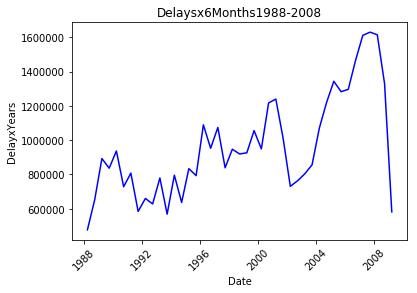

In [11]:
df = pd.read_csv('DelaysxMonths1988-2008.csv')
df['Date'] = pd.to_datetime(df.Date)
df= df.groupby([pd.Grouper(key= 'Date', freq= '2M')])['Delay'].sum()
df=df.reset_index().sort_values('Date') 
df.columns = ['Date','Delay']
df.to_csv('Delaysx2Months1988-2008.csv', encoding='utf-8', index=False)
df = pd.read_csv('DelaysxYears1988-2008.csv',parse_dates = ['Date'],index_col = ['Date'])

fig, ax= plt.subplots()
ax.plot(df.index.values, 
        df['Delay'], 
        color = 'blue')
ax.set(xlabel="Date", ylabel="DelayxYears")
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title("Delaysx6Months1988-2008")

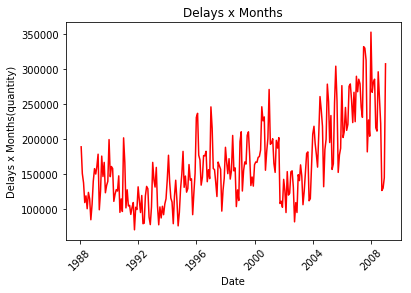

In [12]:
df = pd.read_csv('DelaysxMonths1988-2008.csv',parse_dates = ['Date'],index_col = ['Date'])
fig, ax= plt.subplots()
# add the x-axis and the y-axis to the plot
ax.plot(df.index.values, 
        df['Delay'], 
        color = 'red')
# rotate tick labels
plt.setp(ax.get_xticklabels(), rotation=45)
# set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Delays x Months(quantity)",       
       title="Delays x Months");

plt.savefig("images/DelayxMonths1988-2008.png",bbox_inches = "tight")

1 0.25000000000000006 702647.3172576549
Error de predicción: 24738129674.13


/home/alicia/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/alicia/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


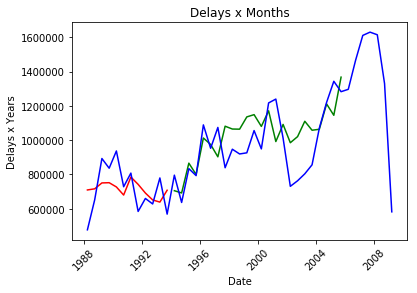

In [15]:
df = pd.read_csv('DelaysxYears1988-2008.csv')
#df= outliers_cuartil(df)

fig, ax= plt.subplots()
ECM = predecir((12),'fusion')
print("Error de predicción: {:.2f}".format(ECM))
ax.plot(df.index.values, 
        df['Delay'], 
        color = 'blue')
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set(xlabel="Date",
       ylabel="Delays x Years",
       title="Delays x Months");

plt.show()

0.25000000000000006 347514.0447077365
Error de predicción: 3431951334.73


/home/alicia/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/alicia/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


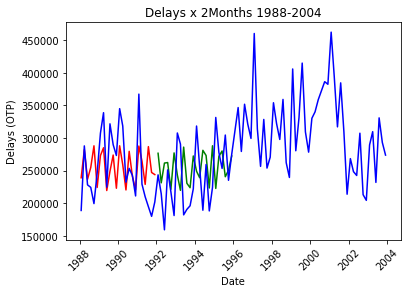

In [16]:
df = pd.read_csv('Delaysx2Months1988-2008.csv')
df = df[0:12*8]
#df= outliers_cuartil(df)
df = outliers_cuartil(df)
fig, ax= plt.subplots()
ECM = predecir(12*2, 'trigo')
print("Error de predicción: {:.2f}".format(ECM))
ax.plot(df.index.values, 
        df['Delay'], 
        color = 'blue')
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set(xlabel="Date",
       ylabel="Delays (OTP)",
       title="Delays x 2Months 1988-2004");
plt.savefig("images/Delay2MonthsPredTrigo1988-1996.png",bbox_inches = "tight")
plt.show()

In [ ]:
Por semana:

0 0.8000000000000005 105766.68653909942
Error de predicción: 173503342.75


/home/alicia/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/alicia/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


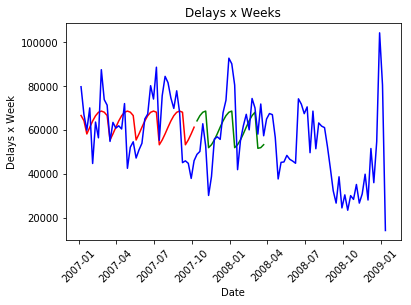

In [19]:
df = pd.read_csv('DelaysxWeeks1988-2008.csv')
df = df[(df['Date'] > '2007-01-01')]
df['Delay'] = df['Delays']
fig, ax= plt.subplots()
ECM = predecir(4*10, 'fusion')
#df.set_index('Date')
print("Error de predicción: {:.2f}".format(ECM))

# add the x-axis and the y-axis to the plot
ax.plot(df.index.values, 
        df['Delay'], 
        color = 'blue')
# rotate tick labels
plt.setp(ax.get_xticklabels(), rotation=45)

# set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Delays x Week",
       title="Delays x Weeks");
plt.savefig("images/ErrDelayxWeek2007-2008Fusion.png")
plt.show()